# Project Mcnulty

Prediction: Home Team Match Outcome

Load data, downloaded from Kaggle and clean up.

PART III - Run Classification Models on just 'goal features' minus DRAWS.

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import sqlite3
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
data = sqlite3.connect('/Users/keerthipamulaparthy/Documents/metis/projects/Project3_McNulty/database.sqlite')

In [2]:
df_raw = pd.read_sql_query(r"""SELECT A.id AS id, A.date AS date, country_id, league_id, season, stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B.buildUpPlaySpeed AS H_bUPS,C.buildUpPlaySpeed AS A_bUPS,B.buildUpPlayDribblingClass AS H_bUPDC, C.buildUpPlayDribblingClass AS A_bUPDC,B.buildUpPlayPassing AS H_bUPP, C.buildUpPlayPassing AS A_bUPP,B.buildUpPlayPositioningClass AS H_bUPPosC, C.buildUpPlayPositioningClass AS A_bUPPosC,B.chanceCreationPassing AS H_cCP, C.chanceCreationPassing AS A_cCP,B.chanceCreationCrossing AS H_cCC, C.chanceCreationCrossing AS A_cCC,B.chanceCreationShooting AS H_cCS, C.chanceCreationShooting AS A_cCS,B.chanceCreationPositioningClass AS H_cCPosC, C.chanceCreationPositioningClass AS A_cCPosC,B.defencePressure AS H_dP, C.defencePressure AS A_dP,B.defenceAggression AS H_dA, C.defenceAggression AS A_dA,B.defenceTeamWidth AS H_dTW, C.defenceTeamWidth AS A_dTW,B.defenceDefenderLineClass AS H_dDLC, C.defenceDefenderLineClass AS A_dDLC FROM Match A JOIN Team_Attributes B ON A.home_team_api_id = B.team_api_id JOIN Team_Attributes C ON A.away_team_api_id = C.team_api_id WHERE substr(A.date,0,5)=substr(B.date,0,5) and substr(A.date,0,5)=substr(C.date,0,5) and season='2014/2015'""", data)


In [4]:
df_raw.head()

,id,date,country_id,league_id,season,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,H_cCPosC,A_cCPosC,H_dP,A_dP,H_dA,A_dA,H_dTW,A_dTW,H_dDLC,A_dDLC
0,1249,2014-07-25 00:00:00,1,1,2014/2015,1,1717817,9985,9986,3,...,Organised,Organised,45,42,54,48,52,49,Cover,Cover
1,1250,2014-07-26 00:00:00,1,1,2014/2015,1,1717818,8475,8342,0,...,Organised,Organised,25,51,37,50,35,57,Cover,Cover
2,1251,2014-07-26 00:00:00,1,1,2014/2015,1,1717819,9984,9991,0,...,Organised,Organised,59,55,47,59,62,52,Cover,Cover
3,1252,2014-07-26 00:00:00,1,1,2014/2015,1,1717820,9989,8573,2,...,Organised,Organised,38,42,49,47,65,44,Cover,Cover
4,1254,2014-07-27 00:00:00,1,1,2014/2015,1,1717822,8203,9987,3,...,Organised,Organised,42,47,51,45,52,55,Cover,Cover


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 35 columns):
id                  3081 non-null int64
date                3081 non-null object
country_id          3081 non-null int64
league_id           3081 non-null int64
season              3081 non-null object
stage               3081 non-null int64
match_api_id        3081 non-null int64
home_team_api_id    3081 non-null int64
away_team_api_id    3081 non-null int64
home_team_goal      3081 non-null int64
away_team_goal      3081 non-null int64
H_bUPS              3081 non-null int64
A_bUPS              3081 non-null int64
H_bUPDC             3081 non-null object
A_bUPDC             3081 non-null object
H_bUPP              3081 non-null int64
A_bUPP              3081 non-null int64
H_bUPPosC           3081 non-null object
A_bUPPosC           3081 non-null object
H_cCP               3081 non-null int64
A_cCP               3081 non-null int64
H_cCC               3081 non-null int64
A_cCC  

In [6]:
df_raw.columns

Index([u'id', u'date', u'country_id', u'league_id', u'season', u'stage',
       u'match_api_id', u'home_team_api_id', u'away_team_api_id',
       u'home_team_goal', u'away_team_goal', u'H_bUPS', u'A_bUPS', u'H_bUPDC',
       u'A_bUPDC', u'H_bUPP', u'A_bUPP', u'H_bUPPosC', u'A_bUPPosC', u'H_cCP',
       u'A_cCP', u'H_cCC', u'A_cCC', u'H_cCS', u'A_cCS', u'H_cCPosC',
       u'A_cCPosC', u'H_dP', u'A_dP', u'H_dA', u'A_dA', u'H_dTW', u'A_dTW',
       u'H_dDLC', u'A_dDLC'],
      dtype='object')

In [7]:
df_2014 = df_raw.reindex(columns = ['date', 
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'hometeam_outcome', 'HT_goalsfor',
    'HT_goalsagainst','AT_goalsfor','AT_goalsagainst'
    ,'H_bUPS','A_bUPS', 'H_bUPDC', 'A_bUPDC', 'H_bUPP', 'A_bUPP', 'H_bUPPosC',
       'A_bUPPosC', 'H_cCP', 'A_cCP', 'H_cCC', 'A_cCC', 'H_cCS',
       'A_cCS', 'H_cCPosC', 'A_cCPosC', 'H_dP', 'A_dP', 'H_dA', 'A_dA',
       'H_dTW', 'A_dTW', 'H_dDLC', 'A_dDLC'])


In [8]:
df_2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 35 columns):
date                3081 non-null object
match_api_id        3081 non-null int64
home_team_api_id    3081 non-null int64
away_team_api_id    3081 non-null int64
home_team_goal      3081 non-null int64
away_team_goal      3081 non-null int64
hometeam_outcome    0 non-null float64
HT_goalsfor         0 non-null float64
HT_goalsagainst     0 non-null float64
AT_goalsfor         0 non-null float64
AT_goalsagainst     0 non-null float64
H_bUPS              3081 non-null int64
A_bUPS              3081 non-null int64
H_bUPDC             3081 non-null object
A_bUPDC             3081 non-null object
H_bUPP              3081 non-null int64
A_bUPP              3081 non-null int64
H_bUPPosC           3081 non-null object
A_bUPPosC           3081 non-null object
H_cCP               3081 non-null int64
A_cCP               3081 non-null int64
H_cCC               3081 non-null int64
A_cCC        

In [9]:
df_2014['hometeam_outcome'] = df_2014['hometeam_outcome'].fillna('')
df_2014['HT_goalsfor'] = df_2014['HT_goalsfor'].fillna('')
df_2014['HT_goalsagainst'] = df_2014['HT_goalsagainst'].fillna('')
df_2014['AT_goalsfor'] = df_2014['AT_goalsfor'].fillna('')
df_2014['AT_goalsagainst'] = df_2014['AT_goalsagainst'].fillna('')

In [10]:
df_2014.loc[df_2014['home_team_goal'] > df_2014['away_team_goal'], 'hometeam_outcome'] = "w"
df_2014.loc[df_2014['home_team_goal'] < df_2014['away_team_goal'], 'hometeam_outcome'] = "l"
df_2014.loc[df_2014['home_team_goal'] == df_2014['away_team_goal'], 'hometeam_outcome'] = "d"

In [11]:
df_2014['hometeam_outcome'].value_counts()

w    1390
l     908
d     783
Name: hometeam_outcome, dtype: int64

In [12]:
df_2014.head()

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,hometeam_outcome,HT_goalsfor,HT_goalsagainst,AT_goalsfor,...,H_cCPosC,A_cCPosC,H_dP,A_dP,H_dA,A_dA,H_dTW,A_dTW,H_dDLC,A_dDLC
0,2014-07-25 00:00:00,1717817,9985,9986,3,0,w,,,,...,Organised,Organised,45,42,54,48,52,49,Cover,Cover
1,2014-07-26 00:00:00,1717818,8475,8342,0,2,l,,,,...,Organised,Organised,25,51,37,50,35,57,Cover,Cover
2,2014-07-26 00:00:00,1717819,9984,9991,0,0,d,,,,...,Organised,Organised,59,55,47,59,62,52,Cover,Cover
3,2014-07-26 00:00:00,1717820,9989,8573,2,0,w,,,,...,Organised,Organised,38,42,49,47,65,44,Cover,Cover
4,2014-07-27 00:00:00,1717822,8203,9987,3,1,w,,,,...,Organised,Organised,42,47,51,45,52,55,Cover,Cover


In [13]:
df_2014_new = df_2014.sort_values('date')
df_2014_new.head()

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,hometeam_outcome,HT_goalsfor,HT_goalsagainst,AT_goalsfor,...,H_cCPosC,A_cCPosC,H_dP,A_dP,H_dA,A_dA,H_dTW,A_dTW,H_dDLC,A_dDLC
1906,2014-07-18 00:00:00,1722098,8033,8023,2,3,l,,,,...,Organised,Organised,29,50,35,60,38,47,Cover,Cover
1903,2014-07-19 00:00:00,1722095,1957,8030,2,2,d,,,,...,Organised,Organised,57,37,56,58,49,63,Cover,Cover
2919,2014-07-19 00:00:00,1717214,9930,9931,1,2,l,,,,...,Organised,Organised,47,47,44,58,54,53,Cover,Cover
2920,2014-07-19 00:00:00,1717215,10190,10192,2,2,d,,,,...,Organised,Organised,40,44,41,34,52,50,Cover,Cover
1902,2014-07-20 00:00:00,1722092,2182,8028,4,0,w,,,,...,Organised,Organised,47,36,47,45,63,48,Cover,Cover


In [14]:
df_2014_new.columns

Index([u'date', u'match_api_id', u'home_team_api_id', u'away_team_api_id',
       u'home_team_goal', u'away_team_goal', u'hometeam_outcome',
       u'HT_goalsfor', u'HT_goalsagainst', u'AT_goalsfor', u'AT_goalsagainst',
       u'H_bUPS', u'A_bUPS', u'H_bUPDC', u'A_bUPDC', u'H_bUPP', u'A_bUPP',
       u'H_bUPPosC', u'A_bUPPosC', u'H_cCP', u'A_cCP', u'H_cCC', u'A_cCC',
       u'H_cCS', u'A_cCS', u'H_cCPosC', u'A_cCPosC', u'H_dP', u'A_dP', u'H_dA',
       u'A_dA', u'H_dTW', u'A_dTW', u'H_dDLC', u'A_dDLC'],
      dtype='object')

In [15]:
df_2014_new.duplicated()

1906    False
1903    False
2919    False
2920    False
1902    False
1904    False
1905    False
2921    False
2922    False
3061    False
3062    False
0       False
1960    False
1       False
1961    False
1963    False
3       False
2       False
2964    False
2965    False
1962    False
5       False
4       False
2966    False
2967    False
1959    False
2034    False
2036    False
70      False
3019    False
        ...  
513     False
512     False
1568    False
1567    False
1573    False
1566    False
1565    False
1572    False
2514    False
2512    False
3050    False
3049    False
3047    False
1571    False
3051    False
3048    False
3055    False
3056    False
3054    False
3053    False
3052    False
1579    False
1580    False
1577    False
1578    False
1576    False
1575    False
1581    False
1583    False
1582    False
dtype: bool

In [16]:
len(df_2014_new)

3081

In [17]:
import datetime
df_2014_new['date'] = pd.to_datetime(df_2014_new['date'])

In [18]:
df_2014_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1906 to 1582
Data columns (total 35 columns):
date                3081 non-null datetime64[ns]
match_api_id        3081 non-null int64
home_team_api_id    3081 non-null int64
away_team_api_id    3081 non-null int64
home_team_goal      3081 non-null int64
away_team_goal      3081 non-null int64
hometeam_outcome    3081 non-null object
HT_goalsfor         3081 non-null object
HT_goalsagainst     3081 non-null object
AT_goalsfor         3081 non-null object
AT_goalsagainst     3081 non-null object
H_bUPS              3081 non-null int64
A_bUPS              3081 non-null int64
H_bUPDC             3081 non-null object
A_bUPDC             3081 non-null object
H_bUPP              3081 non-null int64
A_bUPP              3081 non-null int64
H_bUPPosC           3081 non-null object
A_bUPPosC           3081 non-null object
H_cCP               3081 non-null int64
A_cCP               3081 non-null int64
H_cCC               3081 non-nul

In [19]:
df_2014_new.columns

Index([u'date', u'match_api_id', u'home_team_api_id', u'away_team_api_id',
       u'home_team_goal', u'away_team_goal', u'hometeam_outcome',
       u'HT_goalsfor', u'HT_goalsagainst', u'AT_goalsfor', u'AT_goalsagainst',
       u'H_bUPS', u'A_bUPS', u'H_bUPDC', u'A_bUPDC', u'H_bUPP', u'A_bUPP',
       u'H_bUPPosC', u'A_bUPPosC', u'H_cCP', u'A_cCP', u'H_cCC', u'A_cCC',
       u'H_cCS', u'A_cCS', u'H_cCPosC', u'A_cCPosC', u'H_dP', u'A_dP', u'H_dA',
       u'A_dA', u'H_dTW', u'A_dTW', u'H_dDLC', u'A_dDLC'],
      dtype='object')

In [20]:
df_2014_new.head()

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,hometeam_outcome,HT_goalsfor,HT_goalsagainst,AT_goalsfor,...,H_cCPosC,A_cCPosC,H_dP,A_dP,H_dA,A_dA,H_dTW,A_dTW,H_dDLC,A_dDLC
1906,2014-07-18,1722098,8033,8023,2,3,l,,,,...,Organised,Organised,29,50,35,60,38,47,Cover,Cover
1903,2014-07-19,1722095,1957,8030,2,2,d,,,,...,Organised,Organised,57,37,56,58,49,63,Cover,Cover
2919,2014-07-19,1717214,9930,9931,1,2,l,,,,...,Organised,Organised,47,47,44,58,54,53,Cover,Cover
2920,2014-07-19,1717215,10190,10192,2,2,d,,,,...,Organised,Organised,40,44,41,34,52,50,Cover,Cover
1902,2014-07-20,1722092,2182,8028,4,0,w,,,,...,Organised,Organised,47,36,47,45,63,48,Cover,Cover


In [165]:
len(df_2014_new)

3081

**Feature Engineering - Generating columns, with cummulative goals scored 'for' the home team, and 'against' the home team, cummulative goals scored 'for' the away team, and 'against' the away team **

In [21]:
t1 = df_2014_new.merge(df_2014_new,on='home_team_api_id')
c1 = t1[t1['date_x']>=t1['date_y']].groupby(['match_api_id_x'])['home_team_goal_y','away_team_goal_y'].sum()
t1 = df_2014_new.merge(df_2014_new,left_on='home_team_api_id',right_on='away_team_api_id')
c2 = t1[t1['date_x']>=t1['date_y']].groupby(['match_api_id_x'])['home_team_goal_y','away_team_goal_y'].sum()
t1 = df_2014_new.merge(df_2014_new,on='away_team_api_id')
c3 = t1[t1['date_x']>=t1['date_y']].groupby(['match_api_id_x'])['home_team_goal_y','away_team_goal_y'].sum()
t1 = df_2014_new.merge(df_2014_new,left_on='away_team_api_id',right_on='home_team_api_id')
c4 = t1[t1['date_x']>=t1['date_y']].groupby(['match_api_id_x'])['home_team_goal_y','away_team_goal_y'].sum()

In [22]:
c1.reset_index(level=0,inplace=True)
c2.reset_index(level=0,inplace=True)
c3.reset_index(level=0,inplace=True)
c4.reset_index(level=0,inplace=True)

In [23]:
c = c1.merge(c2,on='match_api_id_x',how='outer').merge(c3,on='match_api_id_x',how='outer').merge(c4,on='match_api_id_x',how='outer')

In [24]:
c.columns = ['match_api_id_x','1','2','3','4','5','6','7','8']

In [25]:
c = c.fillna(0)

In [26]:
c['homegoalsfor'] = c['1']+c['4']
c['homegoalsagainst'] = c['2']+c['3']
c['awaygoalsfor'] = c['6']+c['7']
c['awaygoalsagainst'] = c['5']+c['8']

In [27]:
df_2014_2 = df_2014_new.merge(c,left_on='match_api_id',right_on='match_api_id_x')

In [28]:
df_2014_2.columns

Index([u'date', u'match_api_id', u'home_team_api_id', u'away_team_api_id',
       u'home_team_goal', u'away_team_goal', u'hometeam_outcome',
       u'HT_goalsfor', u'HT_goalsagainst', u'AT_goalsfor', u'AT_goalsagainst',
       u'H_bUPS', u'A_bUPS', u'H_bUPDC', u'A_bUPDC', u'H_bUPP', u'A_bUPP',
       u'H_bUPPosC', u'A_bUPPosC', u'H_cCP', u'A_cCP', u'H_cCC', u'A_cCC',
       u'H_cCS', u'A_cCS', u'H_cCPosC', u'A_cCPosC', u'H_dP', u'A_dP', u'H_dA',
       u'A_dA', u'H_dTW', u'A_dTW', u'H_dDLC', u'A_dDLC', u'match_api_id_x',
       u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'homegoalsfor',
       u'homegoalsagainst', u'awaygoalsfor', u'awaygoalsagainst'],
      dtype='object')

In [29]:
df_2014_2.head()

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,hometeam_outcome,HT_goalsfor,HT_goalsagainst,AT_goalsfor,...,3,4,5,6,7,8,homegoalsfor,homegoalsagainst,awaygoalsfor,awaygoalsagainst
0,2014-07-18,1722098,8033,8023,2,3,l,,,,...,0.0,0.0,2,3,0.0,0.0,2.0,3.0,3.0,2.0
1,2014-07-19,1722095,1957,8030,2,2,d,,,,...,0.0,0.0,2,2,0.0,0.0,2.0,2.0,2.0,2.0
2,2014-07-19,1717214,9930,9931,1,2,l,,,,...,0.0,0.0,1,2,0.0,0.0,1.0,2.0,2.0,1.0
3,2014-07-19,1717215,10190,10192,2,2,d,,,,...,0.0,0.0,2,2,0.0,0.0,2.0,2.0,2.0,2.0
4,2014-07-20,1722092,2182,8028,4,0,w,,,,...,0.0,0.0,4,0,0.0,0.0,4.0,0.0,0.0,4.0


In [30]:
df_2014_2['HT_goalsfor'] = df_2014_2['homegoalsfor'] - df_2014_2['home_team_goal']
df_2014_2['AT_goalsagainst'] = df_2014_2['awaygoalsagainst'] - df_2014_2['home_team_goal']
df_2014_2['HT_goalsagainst'] = df_2014_2['homegoalsagainst'] - df_2014_2['away_team_goal']
df_2014_2['AT_goalsfor'] = df_2014_2['awaygoalsfor'] - df_2014_2['away_team_goal']

In [31]:
df_2014_2.head()

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,hometeam_outcome,HT_goalsfor,HT_goalsagainst,AT_goalsfor,...,3,4,5,6,7,8,homegoalsfor,homegoalsagainst,awaygoalsfor,awaygoalsagainst
0,2014-07-18,1722098,8033,8023,2,3,l,0.0,0.0,0.0,...,0.0,0.0,2,3,0.0,0.0,2.0,3.0,3.0,2.0
1,2014-07-19,1722095,1957,8030,2,2,d,0.0,0.0,0.0,...,0.0,0.0,2,2,0.0,0.0,2.0,2.0,2.0,2.0
2,2014-07-19,1717214,9930,9931,1,2,l,0.0,0.0,0.0,...,0.0,0.0,1,2,0.0,0.0,1.0,2.0,2.0,1.0
3,2014-07-19,1717215,10190,10192,2,2,d,0.0,0.0,0.0,...,0.0,0.0,2,2,0.0,0.0,2.0,2.0,2.0,2.0
4,2014-07-20,1722092,2182,8028,4,0,w,0.0,0.0,0.0,...,0.0,0.0,4,0,0.0,0.0,4.0,0.0,0.0,4.0


In [33]:
df_2014_2.loc[:,['HT_goalsfor','HT_goalsagainst','AT_goalsfor','AT_goalsagainst']].head()

,HT_goalsfor,HT_goalsagainst,AT_goalsfor,AT_goalsagainst
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


**Drop 'draw' matches and calulate accuracy**

In [34]:
df_winloss = df_2014_2.loc[df_2014_2['hometeam_outcome'].isin(['w','l'])]
df_winloss.head()

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,hometeam_outcome,HT_goalsfor,HT_goalsagainst,AT_goalsfor,...,3,4,5,6,7,8,homegoalsfor,homegoalsagainst,awaygoalsfor,awaygoalsagainst
0,2014-07-18,1722098,8033,8023,2,3,l,0.0,0.0,0.0,...,0.0,0.0,2,3,0.0,0.0,2.0,3.0,3.0,2.0
2,2014-07-19,1717214,9930,9931,1,2,l,0.0,0.0,0.0,...,0.0,0.0,1,2,0.0,0.0,1.0,2.0,2.0,1.0
4,2014-07-20,1722092,2182,8028,4,0,w,0.0,0.0,0.0,...,0.0,0.0,4,0,0.0,0.0,4.0,0.0,0.0,4.0
5,2014-07-20,1722096,8027,8245,2,0,w,0.0,0.0,0.0,...,0.0,0.0,2,0,0.0,0.0,2.0,0.0,0.0,2.0
6,2014-07-20,1722097,8025,1601,2,0,w,0.0,0.0,0.0,...,0.0,0.0,2,0,0.0,0.0,2.0,0.0,0.0,2.0


In [35]:
y_train_winloss = df_winloss.loc[df_winloss['date'].dt.year == 2014, 'hometeam_outcome']
y_test_winloss = df_winloss.loc[df_winloss['date'].dt.year == 2015, 'hometeam_outcome']

In [36]:
x_winloss = df_winloss.loc[:,['date', 
       'HT_goalsfor', 'HT_goalsagainst', 'AT_goalsfor', 'AT_goalsagainst']]

In [37]:
x_dummies_winloss = pd.get_dummies(x_winloss)

In [38]:
columns = ['HT_goalsfor','HT_goalsagainst','AT_goalsfor','AT_goalsagainst']
x_train_winloss = x_dummies_winloss.loc[x_dummies_winloss['date'].dt.year == 2014, columns]

x_test_winloss = x_dummies_winloss.loc[x_dummies_winloss['date'].dt.year == 2015, columns]

**Fit a Logistic Regression Model**

In [39]:
logreg = LogisticRegression()
fit = logreg.fit(x_train_winloss,y_train_winloss)

In [40]:
train_acc_winloss = fit.score(x_train_winloss, y_train_winloss)
test_acc_winloss = fit.score(x_test_winloss,y_test_winloss)
#print fit.classes_
train_acc_winloss,test_acc_winloss

(0.6507633587786259, 0.68479999999999996)

In [41]:
y_pred_winloss = fit.predict(x_test_winloss)

In [42]:
precision_recall_fscore_support(y_test_winloss,y_pred_winloss)
print(classification_report(y_test_winloss, y_pred_winloss, target_names=fit.classes_))

             precision    recall  f1-score   support

          l       0.59      0.62      0.61       488
          w       0.75      0.72      0.74       762

avg / total       0.69      0.68      0.69      1250



Goal Features(Win-Loss): Confusion matrix, without normalization


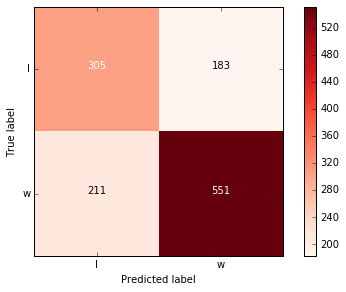

In [44]:
#Confusion Matrix for Log Reg
import itertools
from sklearn.metrics import confusion_matrix

 
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm,title='Confusion matrix', classes=fit.classes_, normalize = False, cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
   # plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        
        print("Goal Features(Win-Loss): Normalized confusion matrix")
    else:
        print('Goal Features(Win-Loss): Confusion matrix, without normalization')

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


 
  

    
 

cnf_matrix = confusion_matrix(y_test_winloss,y_pred_winloss,labels = fit.classes_ )

plot_confusion_matrix(cnf_matrix,fit.classes_)
plt.figure()



**Normalize and do logistic Regression**

In [45]:
from sklearn.preprocessing import normalize

x_train_norm_winloss = normalize(x_train_winloss,axis=0,norm='max')
x_train_norm_winloss = pd.DataFrame(x_train_norm_winloss)

x_test_norm_winloss = normalize(x_test_winloss,axis=0,norm='max')
x_test_norm_winloss = pd.DataFrame(x_test_norm_winloss)

In [46]:
x_train_norm_winloss.columns = x_train_winloss.columns
x_test_norm_winloss.columns = x_test_winloss.columns

In [47]:
logreg = LogisticRegression()
fit = logreg.fit(x_train_norm_winloss,y_train_winloss)

In [48]:
train_acc_winloss=fit.score(x_train_norm_winloss, y_train_winloss)
test_acc_winloss=fit.score(x_test_norm_winloss,y_test_winloss)
y_predlog_winloss = fit.predict(x_test_norm_winloss)

train_acc_winloss,test_acc_winloss

(0.64503816793893132, 0.68079999999999996)

In [49]:
#Precision Recall
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_test_winloss,y_predlog_winloss)
print(classification_report(y_test_winloss,y_predlog_winloss, target_names=fit.classes_))

             precision    recall  f1-score   support

          l       0.59      0.57      0.58       488
          w       0.73      0.75      0.74       762

avg / total       0.68      0.68      0.68      1250



**SVM**

In [50]:
from sklearn import svm
from sklearn import preprocessing

x_train_scaled_winloss = preprocessing.scale(x_train_winloss)
x_test_scaled_winloss = preprocessing.scale(x_test_winloss)

x_train_scaled_winloss = pd.DataFrame(x_train_scaled_winloss)
x_test_scaled_winloss = pd.DataFrame(x_test_scaled_winloss)

In [51]:
x_train_scaled_winloss.columns = x_train_scaled_winloss.columns
x_test_scaled_winloss.columns = x_test_scaled_winloss.columns

In [52]:
clf_svc_winloss = svm.SVC(C=10, kernel='linear', degree=5, gamma=1e-1,)
clf_fit_winloss = clf_svc_winloss.fit(x_train_scaled_winloss, y_train_winloss)

#tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1,1e-1,1e-2,1e-3, 1e-4],
 #                    'C': [1, 10, 100, 1000]},{'kernel': ['linear'], 'C': [1, 10, 100, 1000]},{'kernel':['poly'],'degree':[1,2,3]}]

In [53]:
train_svcacc_winloss=clf_fit_winloss.score(x_train_scaled_winloss, y_train_winloss)
test_svcacc_winloss=clf_fit_winloss.score(x_test_scaled_winloss,y_test_winloss)
y_predSVC_winloss = clf_fit_winloss.predict(x_test_scaled_winloss)

train_svcacc_winloss, test_svcacc_winloss

(0.6354961832061069, 0.68559999999999999)

In [55]:
#Precision Recall
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_test_winloss,y_predSVC_winloss)
print(classification_report(y_test_winloss,y_predSVC_winloss, target_names=clf_fit_winloss.classes_))

             precision    recall  f1-score   support

          l       0.67      0.39      0.49       488
          w       0.69      0.88      0.77       762

avg / total       0.68      0.69      0.66      1250



**Fit a Decision Tree and Random Forest**

In [56]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train_winloss,y_train_winloss)

In [57]:
train_acc_dtree_winloss =clf.score(x_train_winloss, y_train_winloss)
test_acc_dtree_winloss =clf.score(x_test_winloss,y_test_winloss)
train_acc_dtree_winloss,test_acc_dtree_winloss

(0.97137404580152675, 0.63439999999999996)

In [58]:
#Tuning features on Decision Tree
from sklearn.grid_search import GridSearchCV
from sklearn import tree

param_grid = { 
    
   
    'max_depth' : [10,50,100,200],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [1, 25, 50, 100, 150],
   
    
}

dtree_winloss = tree.DecisionTreeClassifier()
CV_dtree_winloss = GridSearchCV(dtree_winloss,param_grid=param_grid)
CV_dtree_winloss.fit(x_train_winloss, y_train_winloss)
print CV_dtree_winloss.best_params_

{'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 50}


In [59]:
dtree_bestparams_winloss = tree.DecisionTreeClassifier(min_samples_split= 2, max_depth =10, min_samples_leaf= 50)
fit_bestdtree_winloss = dtree_bestparams_winloss.fit(x_train_winloss, y_train_winloss)
train_acc_bestdtree_winloss = fit_bestdtree_winloss.score(x_train_winloss, y_train_winloss)
test_acc_bestdtree_winloss = fit_bestdtree_winloss.score(x_test_winloss,y_test_winloss)
y_predDT_winloss= fit_bestdtree_winloss.predict(x_test_winloss)
train_acc_bestdtree_winloss,test_acc_bestdtree_winloss

(0.65839694656488545, 0.48720000000000002)

In [60]:
#Precision Recall
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_test_winloss,y_predDT_winloss)
print(classification_report(y_test_winloss,y_predDT_winloss, target_names=fit_bestdtree_winloss.classes_))

             precision    recall  f1-score   support

          l       0.42      0.85      0.56       488
          w       0.72      0.26      0.38       762

avg / total       0.61      0.49      0.45      1250



In [73]:
clf.classes_

array(['l', 'w'], dtype=object)

In [75]:
from sklearn.ensemble import RandomForestClassifier
clf_forest = RandomForestClassifier()
clf_forest_winloss = clf_forest.fit(x_train_winloss,y_train_winloss)

In [76]:
train_acc_forest_winloss = clf_forest_winloss.score(x_train_winloss, y_train_winloss)
test_acc_forest_winloss = clf_forest_winloss.score(x_test_winloss,y_test_winloss)
train_acc_forest_winloss,test_acc_forest_winloss

(0.95229007633587781, 0.55520000000000003)

**Tuning parameters on Random Forest**

In [79]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = { 
    'n_estimators': [50, 200, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,50,100,200],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [1, 25, 50, 100, 150],
    'n_estimators' : [100,200]
    
}

rfc_winloss = RandomForestClassifier()
CV_rfc_winloss = GridSearchCV(rfc_winloss,param_grid=param_grid)
CV_rfc_winloss.fit(x_train_winloss, y_train_winloss)
print CV_rfc_winloss.best_params_

{'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 25}


In [119]:
rfc_bestparams = RandomForestClassifier(max_features='sqrt', min_samples_split= 10, n_estimators= 100, max_depth= 10,min_samples_leaf= 25)
fit_bestrfc_winloss = rfc_bestparams.fit(x_train_winloss, y_train_winloss)
train_acc_bestforest_winloss = fit_bestrfc_winloss.score(x_train_winloss, y_train_winloss)
test_acc_bestforest_winloss = fit_bestrfc_winloss.score(x_test_winloss,y_test_winloss)
y_predRF_winloss = fit_bestrfc_winloss.predict(x_test_winloss)

train_acc_bestforest_winloss,test_acc_bestforest_winloss

(0.68320610687022898, 0.59199999999999997)

In [123]:
#Precision Recall
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_test_winloss,y_predRF_winloss)
print(classification_report(y_test_winloss,y_predRF_winloss, target_names=fit_bestrfc_winloss.classes_))

             precision    recall  f1-score   support

          l       0.49      0.77      0.60       488
          w       0.76      0.48      0.59       762

avg / total       0.66      0.59      0.59      1250



**KNN**

In [108]:
from sklearn.neighbors import NearestNeighbors
n_neighbors = [5,7,9,11,13,15,17,19]

for n in n_neighbors:
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh_winloss = neigh.fit(x_train_winloss,y_train_winloss)
    knntrain_score_winloss = neigh_winloss.score(x_train_winloss, y_train_winloss)
    knntest_score_winloss = neigh_winloss.score(x_test_winloss, y_test_winloss)
    print n,knntrain_score_winloss,knntest_score_winloss
print neigh_winloss.classes_

5 0.736641221374 0.6272
7 0.713740458015 0.6336
9 0.692748091603 0.6248
11 0.678435114504 0.6408
13 0.675572519084 0.6328
15 0.666030534351 0.6408
17 0.666030534351 0.6472
19 0.661259541985 0.6504
['l' 'w']


In [104]:
knntrain_score_winloss = neigh_winloss.score(x_train_winloss, y_train_winloss)
knntest_score_winloss = neigh_winloss.score(x_test_winloss, y_test_winloss)
y_knnpred_winloss = neigh_winloss.predict(x_test_winloss)
knntrain_score_winloss,knntest_score_winloss


(0.6612595419847328, 0.65039999999999998)

In [109]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_test_winloss,y_knnpred_winloss)
print(classification_report(y_test_winloss,y_knnpred_winloss, target_names=neigh_winloss.classes_))

             precision    recall  f1-score   support

          l       0.54      0.64      0.59       488
          w       0.74      0.65      0.70       762

avg / total       0.66      0.65      0.65      1250



In [133]:
y_train_new = y_train_winloss.replace('w',1)
y_train_new = y_train_winloss.replace('l',0)
y_test_new = y_test_winloss.replace('w',1)
y_test_new = y_test_winloss.replace('l',0)


**Gausian Naive Bayes**

In [88]:
from sklearn.naive_bayes import GaussianNB
clf_gnb = GaussianNB()
clf_gnb_winloss = clf_gnb.fit(x_train_winloss,y_train_winloss)


In [89]:
gnbtrain_score_winloss = clf_gnb_winloss.score(x_train_winloss, y_train_winloss)
gnbtest_score_winloss = clf_gnb_winloss.score(x_test_winloss, y_test_winloss)
gnbtrain_score_winloss,gnbtest_score_winloss

(0.63454198473282442, 0.64159999999999995)